In [1]:
# import
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
# constants
c = 3 * 10 **8
e = 1.6 * 10 **-19
ϵ0 = 8.854 * 10 **-12
me = 0.511 / c**2
mp = 938 / c**2
N_A = 6.022 * 10 **23
m_α = 3727.379 / c**2
W_air = 85.7 * 10 **-6
W_He = 41.8 * 10 **-6
W_Ar = 187 * 10 **-6
Z_α = 2
Ekin_α = 5.486
k_b = 1.38 * 10 **-23
k_air = 14.4
k_He = 2
k_Ar = 18
# MeV/J
MeV_J = 1/e * 10**-6

In [3]:
#measured data
ρ = 0.053
ρ_err = 0.001

background_n = 854
background_n_err = np.sqrt(background_n )
background_t = 3323
background_t_err = 1
background = background_n/background_t
background_err = np.sqrt((background_n_err/background_t)**2+(background_t_err*background_n/background_t**2)**2)

data_n = [434,612,1069,1104,1176,1298,1561,1672,1678,1716,1801,1656,1950,1661,1698,1772,1620,1415,1220,1156,1105,1052,1032,981,910,919,881,852,910,905,904,877,846,809,728,528,402,101,104]
data_n_err = [np.sqrt(n)for n in data_n]
data_t = [992.4,613.4,654.3,520.0,466.8,459.2,488.1,495.6,490.1,461.5,479.9,437.1,493.9,452.9,460.8,488.6,477.8,444.1,411.2,408.8,446.9,469.8,512.0,519.1,498.0,503.8,507.8,495.9,504.0,495.6,498.8,503.6,492.9,502.9,511.5,528.11,713.5,370.5,406]
data_t_err = 0.1
data_I = [1407,1307,1237,1189,1138,1088,1038,998,969,939,909,878,848,818,788,748,709,669,629,589,549,509,478,459,439,418,398,378,358,338,318,298,278,258,238,208,158,108,58]
data_I_err = [I*0.01+1 for I in data_I ]


countrate = []
countrate_err = []
for i in range(len(data_n)):
    countrate.append(data_n[i]/data_t[i]-background)
    countrate_err.append(np.sqrt((data_n_err[i]/data_t[i])**2+(data_t_err*data_n[i]/data_t[i]**2)**2+(background_err)**2))
    

#calibration data
input = 'Data/magnetic_calibration.txt'
i = 0
cal_I = []
cal_B = []
for line in open(input):
    
    if(i > 1):
        d = line.split("\t")
        cal_I.append(float(d[0]))
        cal_B.append(float(d[1]))
    i = i + 1
    
#coulomb correction
G_p = []
G_E = []
G_38 = []
G_39 = []
G_40 = []
i=0
input = 'Data/correction.txt'
for line in open(input):
    
    if(i > 1):
        line = line.replace(",",".")
        d = line.split("\t")
        G_p.append(float(d[0]))
        G_E.append(float(d[1]))
        G_38.append(float(d[2]))
        G_39.append(float(d[3]))
        G_40.append(float(d[4]))
    i = i + 1

    
#countrate
#countrate_err

In [15]:
#theoretical functions
def g(x,m,b):
    return m*x+b

def E_kin(p):
    return np.sqrt(p**2+me**2*c**4)-me*c**2

def E_kin_err(p,p_err):
    return np.sqrt((p_err*p/(np.sqrt(p**2+me**2*c**4)))**2)


def G(E,E_array,G_array):
    i=0
    
    for x in E_array:
        if E<x:
            break
        i+=1 
        if(i>len(G_array)-3):
            break
    result = G_array[i]+(G_array[i+1]-G_array[i])/(E_array[i+1]-E_array[i])*E
    return result 

def S(p,E0):
    return p**2+(E0-E_kin(p))**2

def S_err(p,E0,p_err,E0_err):
    E= E_kin(p)
    E_err= E_kin_err(p,p_err)
    return np.sqrt((2*p*p_err)**2+(2*E0_err*(E0-E))**2+(2*E_err*(E0-E))**2)

def curie(N,p):
    En = E_kin(p)
    return np.sqrt(abs(N/(p**3)))#*En)))

def curie_err(N,p,N_err,p_err):
    #En = E_kin(p)
    #En_err = E_kin_err(p,p_err)
    return np.sqrt((1/2/(p**3)*N_err/np.sqrt(abs(N/(p**3))))**2+(N/(p**4)*p_err/np.sqrt(abs(N/(p**2))))**2);

def curie_coul(N,p,G_Z):
    En = E_kin(p)
    Cor = np.array([G(pi,G_E,G_Z) for pi in p])
    return np.sqrt(abs(N/(p**2*En*Cor)))

#def curie_coul_err(N,p,G_Z,N_err,p_err):
#    Cor = np.array(([G(pi,G_E,G_Z) for pi in p]))
#    return curie_err(N,p,N_err,p_err)/np.sqrt(abs(Cor))
    
def curie_coul_err(N,p,G_Z,N_err,p_err):
    En = E_kin(p)
    En_err = E_kin_err(p,p_err)
    Cor = np.array(([G(pi,G_E,G_Z) for pi in p]))
    return np.sqrt((1/2/(p**2*En)*N_err/np.sqrt(abs(N/(p**2*En))))**2+(1/2*N/(p**2*En**2)*En_err/np.sqrt(abs(N/(p**2*En))))**2+(N/(p**3*En**2)*p_err/np.sqrt(abs(N/(p**2*En))))**2)/np.sqrt(abs(Cor));


def curie_cor(N,p,G_Z,E0):
    En = E_kin(p)
    Cor = np.array([G(pi,G_E,G_Z)*S(pi,E0) for pi in p])
    return np.sqrt(abs(N/(p**2*En*Cor)))

def curie_cor_err(N,p,G_Z,E0,N_err,p_err,E0_err):
    En = E_kin(p)
    En_err = E_kin_err(p,p_err)
    Cor = np.array([G(pi,G_E,G_Z)*S(pi,E0) for pi in p])
    Cor_err = []
    for i in range(len(p)):
        Cor_err.append(G(p[i],G_E,G_Z)*S_err(p[i],E0,p_err[i],E0_err))
    Cor_err = np.array(Cor_err)
    return np.sqrt((1/2/(p**2*En*Cor)*N_err/np.sqrt(abs(N/(p**2*En*Cor))))**2+(1/2*N/(p**2*En**2*Cor)*En_err/np.sqrt(abs(N/(p**2*En*Cor))))**2+(N/(p**3*En*Cor)*p_err/np.sqrt(abs(N/(p**2*En*Cor))))**2+(N/(p**2*En*Cor**2)*Cor_err/np.sqrt(abs(N/(p**2*En*Cor**2))))**2);

def chi2(x,y,sy,f,*k):
    return sum([((y[i]-f(x[i],*k))/f(x[i],*k))**2 for i in range(len(x))])

def chi2_red(x,y,sy,f,*k):
    return chi2(x,y,sy,f,*k)/(len(x)-len(k))

Background Intensity :  0.2569966897381884  +-  0.00879458574077


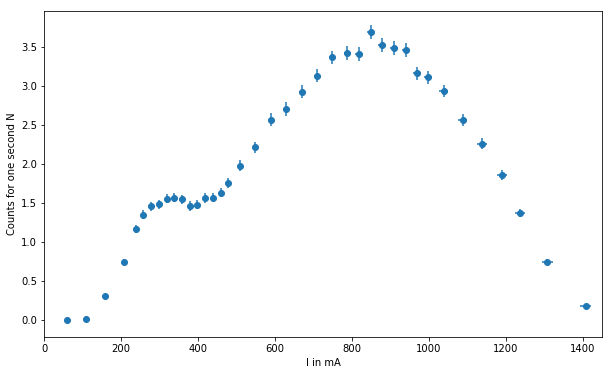

In [5]:
#plot of the counting rate
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(data_I,countrate)
ax.errorbar(data_I,countrate,yerr=countrate_err,xerr=data_I_err,ls="")
ax.set_xlim([0,1450])
ax.set_ylabel("Counts for one second N")
ax.set_xlabel("I in mA")
print("Background Intensity : ",background," +- ",background_err)
fig.savefig("spectrum.pdf")

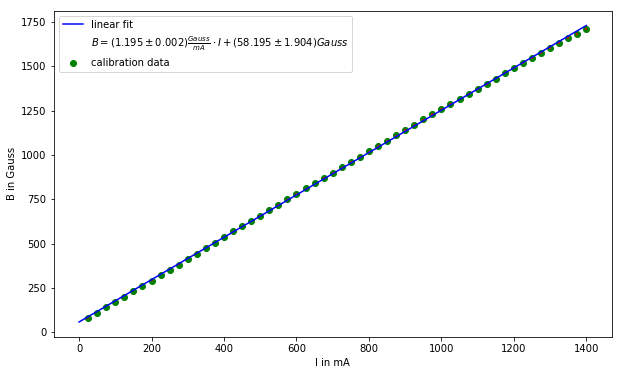

In [6]:
#calibration of the magnetic field
cal_B_err = [0.003*b for b in cal_B]

popt,pcov = curve_fit(g,cal_I,cal_B)
m = popt[0]
m_err = np.sqrt(np.diag(pcov))[0]
b = popt[1]
b_err = np.sqrt(np.diag(pcov))[1]

t=np.linspace(0,1400,100)
fig,ax = plt.subplots(figsize=(10,6))
fitlabel= r"$B = (%0.3f \pm %0.3f)\frac{Gauss}{mA} \cdot I + (%0.3f \pm %0.3f) Gauss$"%(m,m_err,b,b_err)
#fitlabel =" %0.3f \pm \cdot"%(m)
ax.scatter(cal_I,cal_B,c="g",label="calibration data")
ax.errorbar(cal_I,cal_B,yerr=cal_B_err,c="r",ls="")
ax.plot(t,g(t,*popt),c="b",label="linear fit")
ax.plot(t,g(t,*popt),c="b",lw=0,label=fitlabel)
ax.set_xlabel("I in mA")
ax.set_ylabel("B in Gauss")
ax.legend(loc="best")
fig.savefig("magnet_calibration.pdf")


B = g(np.array(data_I),m,b)*10**-4
#B_err = [0.003*b for b in B]
B_err = []
for i in range(len(data_I)):
    err = np.sqrt((data_I_err[i]*m)**2+(data_I[i]*m_err)**2+(b_err)**2)*10**-4
    B_err.append(err)

    
    
#calculation of momentum p and energy E
    
p = B*ρ*e*(c/e*10**-6)
p_err = []
for i in range(len(B)):
    p_err.append(np.sqrt((B[i]*ρ_err)**2+(B_err[i]*ρ)**2)*e*(c/e*10**-6))
E = E_kin(p)
E_err = E_kin_err(p,p_err)


In [7]:
#fig,ax = plt.subplots(figsize=(10,6))
#ax.scatter(p,countrate/p)
#ax.set_xlim(0,3)

Y -> Zr : Ekin0 =  2.39885754578  +-  0.0162567325546
Sr -> Y : Ekin0 =  0.502625755767  +-  0.0170355126648
chi squared 1 right =  0.0723539733821
chi squared 2 left =  0.00117876114083
correlation squared 1 right =  0.87089302899
correlation squared 2 left =  0.953021575681


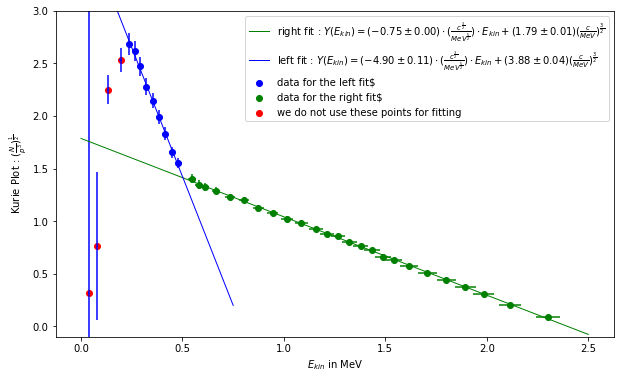

In [27]:
#Curie Plot witout corrections
popt, pcov = curve_fit(g,E[:25],curie(countrate,p)[:25])
m1= popt[0]
m1_err = np.sqrt(np.diag(pcov))[0]
b1 = popt[1]
b1_err = np.sqrt(np.diag(pcov))[1]
t1 = np.linspace(0,2.5,100)

cor1 = pcov[0][1]**2/(pcov[0][0]*pcov[1][1])

popt, pcov = curve_fit(g,E[26:35],curie(countrate,p)[26:35])
m2= popt[0]
m2_err = np.sqrt(np.diag(pcov))[0]
b2 = popt[1]
b2_err = np.sqrt(np.diag(pcov))[1]
t2 = np.linspace(0,0.75,100)

cor2 = pcov[0][1]**2/(pcov[0][0]*pcov[1][1])

cur_err = curie_err(np.array(countrate),np.array(p),np.array(countrate_err),np.array(p_err))

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(E[26:35],curie(countrate,p)[26:35],c="b",label="data for the left fit$")##left part
ax.errorbar(E[26:35],curie(countrate,p)[26:35],xerr=E_err[26:35],yerr=cur_err[26:35],c="b",ls=" ")
ax.scatter(E[:25],curie(countrate,p)[:25],c="g",label="data for the right fit$")##right part
ax.errorbar(E[:25],curie(countrate,p)[:25],xerr=E_err[:25],yerr=cur_err[:25],c="g",ls=" ")   ##FF6300
ax.plot(t1,g(t1,m1,b1),c="g",lw=1,label=r"right fit : $Y(E_{kin})= (%0.2f \pm %0.2f)\cdot (\frac{c^\frac{3}{2}}{MeV^\frac{5}{2}}) \cdot E_{kin} + (%0.2f \pm %0.2f) (\frac{c}{MeV})^\frac{3}{2}$"%(m1,m1_err,b1,b1_err))
ax.plot(t2,g(t2,m2,b2),c="b",lw=1,label=r"left fit : $Y(E_{kin})= (%0.2f \pm %0.2f)\cdot (\frac{c^\frac{3}{2}}{MeV^\frac{5}{2}}) \cdot E_{kin} + (%0.2f \pm %0.2f) (\frac{c}{MeV})^\frac{3}{2}$"%(m2,m2_err,b2,b2_err))
ax.scatter(E[-4:],curie(countrate,p)[-4:],c="r",label="we do not use these points for fitting")#discarded points
ax.errorbar(E[-4:],curie(countrate,p)[-4:],xerr=E_err[-4:],yerr=cur_err[-4:],c="b",ls=" ")
ax.set_ylim([-0.1,3])
ax.set_xlabel("$E_{kin}$ in MeV")
ax.set_ylabel(r"Kurie Plot : $(\frac{N}{p^3})^{\frac{1}{2}}$")

ax.legend(loc=("best"))
fig.savefig("curie_without.pdf")

chi2_1 = chi2(E[:25],curie(countrate,p)[:25],cur_err[:25],g,m1,b1)
chi2_2 = chi2(E[26:35],curie(countrate,p)[26:35],cur_err[26:35],g,m2,b2)


E1 = -b1/m1
E1_err = np.sqrt((b1_err/m1)**2+(m1_err*b1/m1**2)**2)
E2 = -(b1-b2)/(m1-m2)
E2_err = np.sqrt((b1_err/(m1-m2))**2+(b2_err/(m1-m2))**2+(m1_err*(b1-b2)/(m1-m2)**2)**2+(m2_err*(b1-b2)/(m1-m2)**2)**2)

print("Y -> Zr : Ekin0 = ",E1," +- ",E1_err)
print("Sr -> Y : Ekin0 = ",E2," +- ",E2_err)
print("chi squared 1 right = ",chi2_1)
print("chi squared 2 left = ",chi2_2)
print("correlation squared 1 right = ",cor1)
print("correlation squared 2 left = ",cor2)

In [ ]:
# G interpolation

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(G_E,G_38,c="g")
ax.plot(G_E,G_38,label="Z = 38",c="g")
ax.scatter(G_E,G_39,c="r")
ax.plot(G_E,G_39,label="Z = 39",c="r")
ax.scatter(G_E,G_40,c="b")
ax.plot(G_E,G_40,label="Z = 40",c="b")
ax.set_xlabel("E in MeV")
ax.set_ylabel(r"G(E) in $\frac{1}{c}$")
ax.legend()
fig.savefig("g_factor.pdf")

Y -> Zr : Ekin0 =  2.32711262114  +-  0.0416283605029
Sr -> Y : Ekin0 =  0.507207994795  +-  0.0192130355445
chi squared 1 right =  0.421029735554
chi squared 2 left =  0.000464771878302
correlation squared 1 right =  0.870893028627
correlation squared 2 left =  0.953021573171


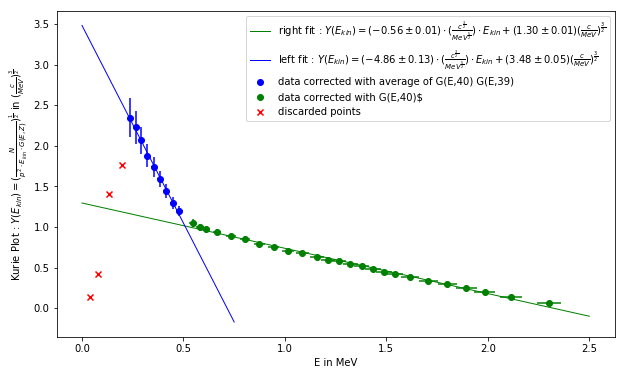

In [34]:
#Curie Plot with coulomb
popt, pcov = curve_fit(g,E[:25],curie_coul(countrate,p,G_40)[:25])
m1= popt[0]
m1_err = np.sqrt(np.diag(pcov))[0]
b1 = popt[1]
b1_err = np.sqrt(np.diag(pcov))[1]
t1 = np.linspace(0,2.5,100)

cor1 = pcov[0][1]**2/(pcov[0][0]*pcov[1][1])

popt, pcov = curve_fit(g,E[26:35],curie_coul(countrate,p,G_39)[26:35])
m2= popt[0]
m2_err = np.sqrt(np.diag(pcov))[0]
b2 = popt[1]
b2_err = np.sqrt(np.diag(pcov))[1]
t2 = np.linspace(0,0.75,100)

cor2 = pcov[0][1]**2/(pcov[0][0]*pcov[1][1])

cur_err_40 = curie_coul_err(np.array(countrate),np.array(p),np.array(G_40),np.array(countrate_err),np.array(p_err))
cur_err_39 = curie_coul_err(np.array(countrate),np.array(p),np.array(G_39),np.array(countrate_err),np.array(p_err))

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(E[26:35],curie_coul(countrate,p,G_39)[26:35],c="b",label="data corrected with average of G(E,40) G(E,39)")##left part
ax.errorbar(E[26:35],curie_coul(countrate,p,G_39)[26:35],xerr=E_err[26:35],yerr=cur_err_39[26:35],c="b",ls=" ")
ax.scatter(E[:25],curie_coul(countrate,p,G_40)[:25],c="g",label="data corrected with G(E,40)$")##right part
ax.errorbar(E[:25],curie_coul(countrate,p,G_40)[:25],xerr=E_err[:25],yerr=cur_err_40[:25],c="g",ls=" ")   ##FF6300
ax.plot(t1,g(t1,m1,b1),c="g",lw=1,label=r"right fit : $Y(E_{kin})= (%0.2f \pm %0.2f)\cdot (\frac{c^\frac{3}{2}}{MeV^\frac{5}{2}}) \cdot E_{kin} + (%0.2f \pm %0.2f) (\frac{c}{MeV})^\frac{3}{2}$"%(m1,m1_err,b1,b1_err))
ax.plot(t2,g(t2,m2,b2),c="b",lw=1,label=r"left fit : $Y(E_{kin})= (%0.2f \pm %0.2f)\cdot (\frac{c^\frac{3}{2}}{MeV^\frac{5}{2}}) \cdot E_{kin} + (%0.2f \pm %0.2f) (\frac{c}{MeV})^\frac{3}{2}$"%(m2,m2_err,b2,b2_err))
ax.scatter(E[-4:],curie(countrate,p)[-4:],marker="x",c="red",label="discarded points")#discarded points
ax.set_xlabel("E in MeV")
ax.set_ylabel(r"Kurie Plot : $Y(E_{kin}) = (\frac{N}{p^2\cdot  E_{kin}\cdot G(E,Z)})^{\frac{1}{2}}$ in $ (\frac{c}{MeV})^\frac{3}{2}$ ")
ax.legend(loc=("best"))
fig.savefig("kurie_coul.pdf")


chi2_1 = chi2_red(E[:25],curie_coul(countrate,p,G_40)[:25],cur_err_40[:25],g,m1,b1)
chi2_2 = chi2_red(E[26:35],curie_coul(countrate,p,G_39)[26:35],cur_err_40[26:35],g,m2,b2)


E1 = -b1/m1
E1_err = np.sqrt((b1_err/m1)**2+(m1_err*b1/m1**2)**2)
E2 = -(b1-b2)/(m1-m2)
E2_err = np.sqrt((b1_err/(m1-m2))**2+(b2_err/(m1-m2))**2+(m1_err*(b1-b2)/(m1-m2)**2)**2+(m2_err*(b1-b2)/(m1-m2)**2)**2)

print("Y -> Zr : Ekin0 = ",E1," +- ",E1_err)
print("Sr -> Y : Ekin0 = ",E2," +- ",E2_err)
print("chi squared 1 right = ",chi2_1)
print("chi squared 2 left = ",chi2_2)
print("correlation squared 1 right = ",cor1)
print("correlation squared 2 left = ",cor2)


0
Y -> Zr : Ekin0 =  2.25245935185  +-  0.0404734001144
Sr -> Y : Ekin0 =  0.552395741003  +-  0.030036328837
chi squared 1 right =  2.52357485025
chi squared 2 left =  0.110936216661
correlation squared 1 right =  0.870893029012
correlation squared 2 left =  0.953021575792


1
Y -> Zr : Ekin0 =  2.23969272088  +-  0.0442756003875
Sr -> Y : Ekin0 =  0.556073059054  +-  0.0279476535772
chi squared 1 right =  2.07208388103
chi squared 2 left =  0.101212210305
correlation squared 1 right =  0.870893027171
correlation squared 2 left =  0.953021574527


2
Y -> Zr : Ekin0 =  2.23745817295  +-  0.0449646798617
Sr -> Y : Ekin0 =  0.556215979336  +-  0.0277817719631
chi squared 1 right =  2.01984612121
chi squared 2 left =  0.100369909856
correlation squared 1 right =  0.870893028612
correlation squared 2 left =  0.953021575554


3
Y -> Zr : Ekin0 =  2.23706565217  +-  0.0450864363331
Sr -> Y : Ekin0 =  0.556182165602  +-  0.0277748648445
chi squared 1 right =  2.01126967647
chi squared 2 left

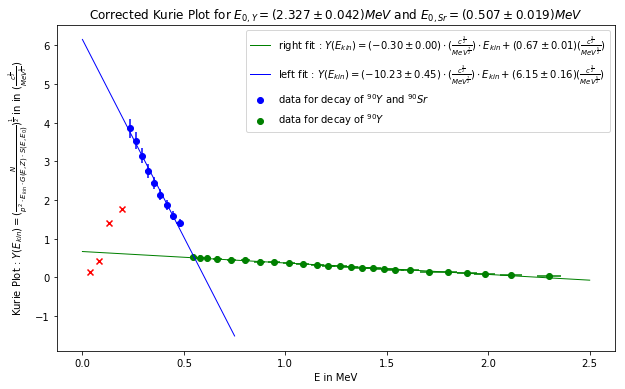

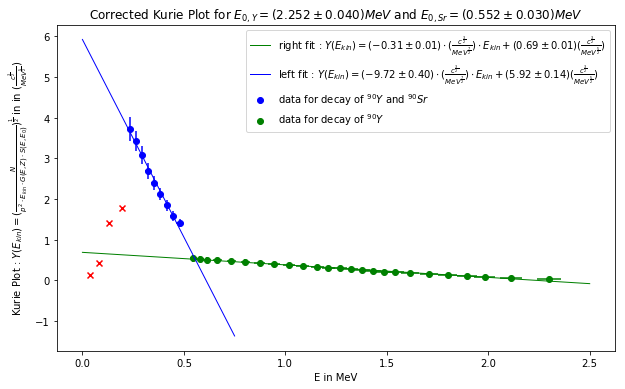

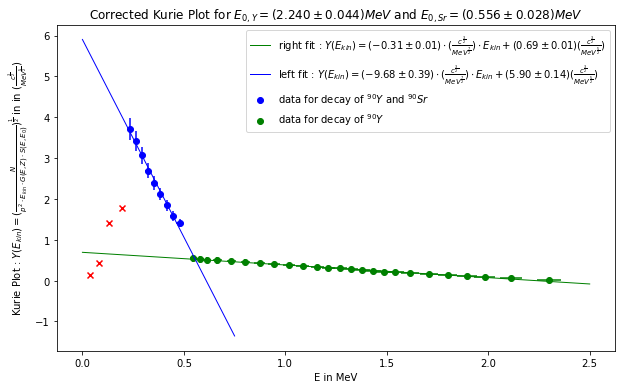

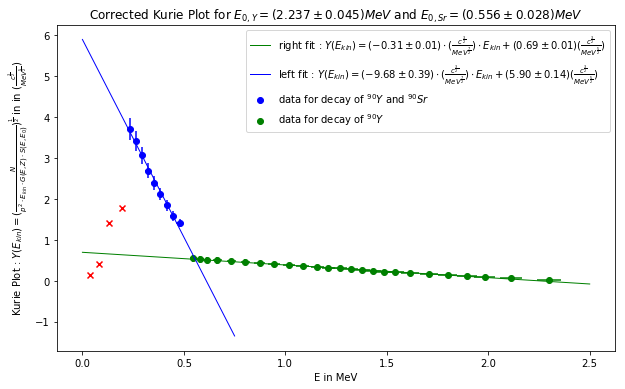

In [35]:
#Curie Plot with coulomb and S correction
E0_1 = 2.327
E0_2 = 0.507
E0_1_err = 0.042 
E0_2_err = 0.019

for i in range(4):

    popt, pcov = curve_fit(g,E[:25],curie_cor(countrate,p,G_40,E0_1)[:25])
    m1= popt[0]
    m1_err = np.sqrt(np.diag(pcov))[0]
    b1 = popt[1]
    b1_err = np.sqrt(np.diag(pcov))[1]
    t1 = np.linspace(0,2.5,100)

    cor1 = pcov[0][1]**2/(pcov[0][0]*pcov[1][1])

    popt, pcov = curve_fit(g,E[26:35],curie_cor(countrate,p,G_39,E0_2)[26:35])
    m2= popt[0]
    m2_err = np.sqrt(np.diag(pcov))[0]
    b2 = popt[1]
    b2_err = np.sqrt(np.diag(pcov))[1]
    t2 = np.linspace(0,0.75,100)

    cor2 = pcov[0][1]**2/(pcov[0][0]*pcov[1][1])

    cur_err_40 = curie_cor_err(np.array(countrate),np.array(p),np.array(G_40),E0_1,np.array(countrate_err),np.array(p_err),E0_1_err)
    cur_err_39 = curie_cor_err(np.array(countrate),np.array(p),np.array(G_39),E0_2,np.array(countrate_err),np.array(p_err),E0_2_err)

    fig,ax = plt.subplots(figsize=(10,6))
    ax.scatter(E[26:35],curie_cor(countrate,p,G_39,E0_2)[26:35],c="b",label="data for decay of $^{90} Y$ and $^{90} Sr$")##left part
    ax.errorbar(E[26:35],curie_cor(countrate,p,G_39,E0_2)[26:35],xerr=E_err[26:35],yerr=cur_err_39[26:35],c="b",ls=" ")
    ax.scatter(E[:25],curie_cor(countrate,p,G_40,E0_1)[:25],c="g",label="data for decay of $^{90} Y $")##right part
    ax.errorbar(E[:25],curie_cor(countrate,p,G_40,E0_1)[:25],xerr=E_err[:25],yerr=cur_err_40[:25],c="g",ls=" ")   ##FF6300
    ax.plot(t1,g(t1,m1,b1),c="g",lw=1,label=r"right fit : $Y(E_{kin})= (%0.2f \pm %0.2f)\cdot (\frac{c^\frac{3}{2}}{MeV^\frac{7}{2}}) \cdot E_{kin} + (%0.2f \pm %0.2f) (\frac{c^\frac{3}{2}}{MeV^\frac{5}{2}})$"%(m1,m1_err,b1,b1_err))
    ax.plot(t2,g(t2,m2,b2),c="b",lw=1,label=r"left fit : $Y(E_{kin})= (%0.2f \pm %0.2f)\cdot (\frac{c^\frac{3}{2}}{MeV^\frac{7}{2}}) \cdot E_{kin} + (%0.2f \pm %0.2f) (\frac{c^\frac{3}{2}}{MeV^\frac{5}{2}})$"%(m2,m2_err,b2,b2_err))
    ax.scatter(E[-4:],curie(countrate,p)[-4:],marker="x",c="red")#discarded points
    ax.set_xlabel("E in MeV")
    ax.set_ylabel(r"Kurie Plot : $Y(E_{kin}) = (\frac{N}{p^2\cdot  E_{kin}\cdot G(E,Z) \cdot S(E,E_0)})^{\frac{1}{2}}$ in in $ (\frac{c^\frac{3}{2}}{MeV^\frac{5}{2}})$")
    ax.set_title("Corrected Kurie Plot for $E_{0,Y} = (%0.3f \pm %0.3f) MeV$ and $E_{0,Sr} = (%0.3f \pm %0.3f) MeV$"%(E0_1,E0_1_err,E0_2,E0_2_err))

    chi2_1 = chi2_red(E[:25],curie_coul(countrate,p,G_40)[:25],cur_err_40[:25],g,m1,b1)
    chi2_2 = chi2_red(E[26:35],curie_coul(countrate,p,G_39)[26:35],cur_err_40[26:35],g,m2,b2)

    ax.legend(loc=("best"))
    fig.savefig("Kurie_cor"+str(i)+".pdf")
    
    E1 = -b1/m1
    E1_err = np.sqrt((b1_err/m1)**2+(m1_err*b1/m1**2)**2)
    E2 = -(b1-b2)/(m1-m2)
    E2_err = np.sqrt((b1_err/(m1-m2))**2+(b2_err/(m1-m2))**2+(m1_err*(b1-b2)/(m1-m2)**2)**2+(m2_err*(b1-b2)/(m1-m2)**2)**2)

    print()
    print(i)
    print("Y -> Zr : Ekin0 = ",E1," +- ",E1_err)
    print("Sr -> Y : Ekin0 = ",E2," +- ",E2_err)
    print("chi squared 1 right = ",chi2_1)
    print("chi squared 2 left = ",chi2_2)
    print("correlation squared 1 right = ",cor1)
    print("correlation squared 2 left = ",cor2)
    print()
    
    E0_1 = E1
    E0_2 = E2
    E0_1_err = E1_err
    E0_2_err = E2_err


Y -> Zr : Ekin0 =  2.23698453143  +-  0.0451116261332
Sr -> Y : Ekin0 =  0.556166285619  +-  0.0277767902735
chi squared 1 right =  58.6228442696
chi squared 2 left =  35.0649909206
correlation squared 1 right =  0.870893028659
correlation squared 2 left =  0.953021573933



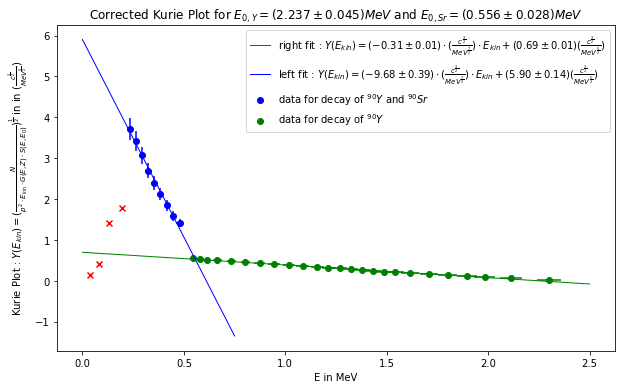

In [19]:
popt, pcov = curve_fit(g,E[:25],curie_cor(countrate,p,G_40,E0_1)[:25])
m1= popt[0]
m1_err = np.sqrt(np.diag(pcov))[0]
b1 = popt[1]
b1_err = np.sqrt(np.diag(pcov))[1]
t1 = np.linspace(0,2.5,100)

cor1 = pcov[0][1]**2/(pcov[0][0]*pcov[1][1])

popt, pcov = curve_fit(g,E[26:35],curie_cor(countrate,p,G_39,E0_2)[26:35])
m2= popt[0]
m2_err = np.sqrt(np.diag(pcov))[0]
b2 = popt[1]
b2_err = np.sqrt(np.diag(pcov))[1]
t2 = np.linspace(0,0.75,100)

cor2 = pcov[0][1]**2/(pcov[0][0]*pcov[1][1])

cur_err_40 = curie_cor_err(np.array(countrate),np.array(p),np.array(G_40),E0_1,np.array(countrate_err),np.array(p_err),E0_1_err)
cur_err_39 = curie_cor_err(np.array(countrate),np.array(p),np.array(G_39),E0_2,np.array(countrate_err),np.array(p_err),E0_2_err)

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(E[26:35],curie_cor(countrate,p,G_39,E0_2)[26:35],c="b",label="data for decay of $^{90} Y$ and $^{90} Sr$")##left part
ax.errorbar(E[26:35],curie_cor(countrate,p,G_39,E0_2)[26:35],xerr=E_err[26:35],yerr=cur_err_39[26:35],c="b",ls=" ")
ax.scatter(E[:25],curie_cor(countrate,p,G_40,E0_1)[:25],c="g",label="data for decay of $^{90} Y $")##right part
ax.errorbar(E[:25],curie_cor(countrate,p,G_40,E0_1)[:25],xerr=E_err[:25],yerr=cur_err_40[:25],c="g",ls=" ")   ##FF6300
ax.plot(t1,g(t1,m1,b1),c="g",lw=1,label=r"right fit : $Y(E_{kin})= (%0.2f \pm %0.2f)\cdot (\frac{c^\frac{3}{2}}{MeV^\frac{7}{2}}) \cdot E_{kin} + (%0.2f \pm %0.2f) (\frac{c^\frac{3}{2}}{MeV^\frac{5}{2}})$"%(m1,m1_err,b1,b1_err))
ax.plot(t2,g(t2,m2,b2),c="b",lw=1,label=r"left fit : $Y(E_{kin})= (%0.2f \pm %0.2f)\cdot (\frac{c^\frac{3}{2}}{MeV^\frac{7}{2}}) \cdot E_{kin} + (%0.2f \pm %0.2f) (\frac{c^\frac{3}{2}}{MeV^\frac{5}{2}})$"%(m2,m2_err,b2,b2_err))
ax.scatter(E[-4:],curie(countrate,p)[-4:],marker="x",c="red")#discarded points
ax.set_xlabel("E in MeV")
ax.set_ylabel(r"Kurie Plot : $Y(E_{kin}) = (\frac{N}{p^2\cdot  E_{kin}\cdot G(E,Z) \cdot S(E,E_0)})^{\frac{1}{2}}$ in in $ (\frac{c^\frac{3}{2}}{MeV^\frac{5}{2}})$")
ax.set_title("Corrected Kurie Plot for $E_{0,Y} = (%0.3f \pm %0.3f) MeV$ and $E_{0,Sr} = (%0.3f \pm %0.3f) MeV$"%(E0_1,E0_1_err,E0_2,E0_2_err))

chi2_1 = chi2_red(E[:25],curie_coul(countrate,p,G_40)[:25],cur_err_40[:25],g,m1,b1)
chi2_2 = chi2_red(E[26:35],curie_coul(countrate,p,G_39)[26:35],cur_err_40[26:35],g,m2,b2)

ax.legend(loc=("best"))
E1 = -b1/m1
E1_err = np.sqrt((b1_err/m1)**2+(m1_err*b1/m1**2)**2)
E2 = -(b1-b2)/(m1-m2)
E2_err = np.sqrt((b1_err/(m1-m2))**2+(b2_err/(m1-m2))**2+(m1_err*(b1-b2)/(m1-m2)**2)**2+(m2_err*(b1-b2)/(m1-m2)**2)**2)

print()
print("Y -> Zr : Ekin0 = ",E1," +- ",E1_err)
print("Sr -> Y : Ekin0 = ",E2," +- ",E2_err)
print("chi squared 1 right = ",chi2_1)
print("chi squared 2 left = ",chi2_2)
print("correlation squared 1 right = ",cor1)
print("correlation squared 2 left = ",cor2)
print()